In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

batch_size = 128
num_epochs = 100
seed = 1
out_dir = './mnist_cnnvae'

In [2]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')
    
device="cuda:0" if cuda else "cpu"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

cuda is available!


In [3]:
# (image, label) = [(batch,channel,h,w), (batch)] channel=1
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=False,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

$$
H_{out}=\text{int}\left(\frac{H_{in}+2\times\text{padding}-(\text{kernel_size}-1)-1}{\text{stride}}+1\right)
$$

In [19]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=8,kernel_size=5,stride=2,padding=5//2) # (batch, 1, 28, 28)->(batch, 8, 14, 14)
        self.conv2=nn.Conv2d(in_channels=8, out_channels=16,kernel_size=5,stride=2,padding=5//2) # (batch, 8, 14, 14)->(batch, 16, 7, 7)
        self.fc1 = nn.Linear(16*7*7, 512)
        self.fc21 = nn.Linear(512, 100)  # mu
        self.fc22 = nn.Linear(512, 100)  # logvar

        self.deconv1=nn.ConvTranspose2d()
        self.fc3 = nn.Linear(100, 512)
        self.fc4 = nn.Linear(512, 784)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))
    
    def forward(self, x):
        x = self.conv1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.relu(x)
        x = x.view(-1, 16*7*7)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
def loss_function(recon_x, x, mu, logvar):
    # size_average=Falseなのでバッチ内のサンプルの合計lossを求める
    # reconstruction loss 入力画像をどのくらい正確に復元できたか？
    # 数式では対数尤度の最大化だが交差エントロピーlossの最小化と等価
    recon = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), size_average=False)

    # 潜在空間zに対する正則化項
    # P(z|x) が N(0, I)に近くなる（KL-distanceが小さくなる）ようにする
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon + kld

In [21]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
    
    # loss_function() は平均ではなく全サンプルの合計lossを返すのでサンプル数で割る
    train_loss /= len(train_loader.dataset)

    return train_loss
    

def test(epoch):
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        data.to(device)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.data
        
        if epoch % 10 == 0:
            # 10エポックごとに最初のminibatchの入力画像と復元画像を保存
            if batch_idx == 0:
                n = 8
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.data.cpu(),
                           '{}/reconstruction_{}.png'.format(out_dir, epoch), nrow=n)

    test_loss /= len(test_loader.dataset)

    return test_loss

loss_list = []
test_loss_list = []
for epoch in range(1, num_epochs + 1):
    loss = train(epoch)
    test_loss = test(epoch)
    
    if epoch%5==0:
        print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
            epoch,
            num_epochs,
            loss,
            test_loss))

    # logging
    loss_list.append(loss)
    test_loss_list.append(test_loss)

# save the training model
np.save(out_dir+'/loss_list.npy', np.array(loss_list))
np.save(out_dir+'/test_loss_list.npy', np.array(test_loss_list))
torch.save(model.state_dict(), out_dir+'/vae.pth')

/home/pip/junya_yasuda/.conda/envs/py36-yasuda/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/pip/junya_yasuda/.conda/envs/py36-yasuda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


epoch [1/100], loss: 183.5977 test_loss: 140.4578
epoch [2/100], loss: 136.5304 test_loss: 116.4549
epoch [3/100], loss: 120.9928 test_loss: 106.9462
epoch [4/100], loss: 114.2439 test_loss: 102.4967
epoch [5/100], loss: 110.8648 test_loss: 99.8001
epoch [6/100], loss: 108.8264 test_loss: 98.7966
epoch [7/100], loss: 107.5912 test_loss: 97.5984
epoch [8/100], loss: 106.7063 test_loss: 96.3665
epoch [9/100], loss: 106.0904 test_loss: 96.1010
epoch [10/100], loss: 105.4969 test_loss: 95.6982
epoch [11/100], loss: 105.1199 test_loss: 96.0572
epoch [12/100], loss: 104.7879 test_loss: 94.7624
epoch [13/100], loss: 104.4489 test_loss: 94.6551
epoch [14/100], loss: 104.1753 test_loss: 94.5180
epoch [15/100], loss: 103.9132 test_loss: 94.5991
epoch [16/100], loss: 103.6804 test_loss: 94.0257
epoch [17/100], loss: 103.4250 test_loss: 93.6865
epoch [18/100], loss: 103.2128 test_loss: 94.5246
epoch [19/100], loss: 103.0835 test_loss: 93.7266
epoch [20/100], loss: 102.8954 test_loss: 93.6156
epoch

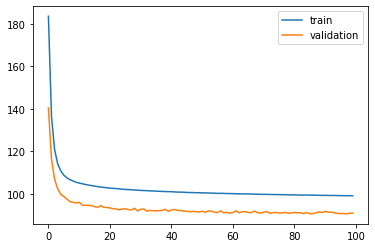

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
x = [i for i in range(len(loss_list))]
plt.plot(x, loss_list, label="train")
plt.plot(x, test_loss_list, label="validation")
plt.legend()
plt.show()

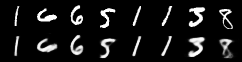

In [22]:
from IPython.display import Image
Image(out_dir+'/reconstruction_10.png')

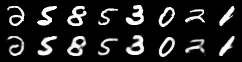

In [23]:
Image(out_dir+'/reconstruction_100.png')